In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
#column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               # 'Acceleration', 'Model Year', 'Origin']
#col_names = ["GlaThiDa_ID", "POLITICAL_UNIT", "GLACIER_NAME", "SURVEY_DATE", "PROFILE_ID", "POINT_ID", "POINT_LAT", "POINT_LON", "ELEVATION", "THICKNESS", "THICKNESS_UNCERTAINTY", "DATA_FLAG"]

raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/TTT.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac_thick/data/TTT.csv")

dataset = raw_dataset.copy()



2.5.0


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
dataset.tail()

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
3854274,6630,AT,MULLWITZKEES,19989999.0,NaN,27,47.092690,12.380504,3329.0,36,4.0,NaN,NaN
3854275,6630,AT,MULLWITZKEES,19989999.0,NaN,28,47.093780,12.379642,3353.0,26,3.0,NaN,NaN
3854276,6630,AT,MULLWITZKEES,19989999.0,NaN,29,47.094839,12.378200,3381.0,39,4.0,NaN,NaN
3854277,6630,AT,MULLWITZKEES,19989999.0,NaN,30,47.094829,12.378174,3381.0,39,4.0,NaN,NaN
3854278,6631,AT,MULLWITZKEES,20039999.0,NaN,1,47.094853,12.374525,3369.0,50,5.0,NaN,NaN


In [16]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("PROFILE_ID", axis=1)
dataset = dataset.drop("POINT_ID", axis=1)
dataset = dataset.drop("THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
 
dataset = dataset.dropna()

In [17]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [18]:
# sns.pairplot(train_dataset[["THICKNESS", "ELEVATION", "POINT_LAT", "POINT_LON"]], diag_kind='kde')

In [19]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
POINT_LAT,2698267.0,47.477816,53.238428,-78.305458,46.405156,70.346832,78.809574,82.963377
POINT_LON,2698267.0,-46.458083,45.484560,-149.046814,-78.210226,-67.742430,7.805468,170.284390
ELEVATION,2698267.0,1175.033891,937.446613,-839.000000,431.000000,898.000000,1686.000000,7846.000000
THICKNESS,2698267.0,295.750914,243.823599,0.000000,96.000000,259.000000,435.000000,3151.000000


In [20]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("THICKNESS")
test_labels = test_features.pop("THICKNESS")

In [21]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
POINT_LAT,47.477816,53.238428
POINT_LON,-46.458083,45.484560
ELEVATION,1175.033891,937.446613


In [22]:
normalizer = preprocessing.Normalization(axis=-1)

In [23]:
#had to convert train features to float to use the normalizer.
#already was float, but internet told me to change it and now it works
#train_features_x = np.asarray(train_features).astype(np.float32)
#reran notebook and problem went away
normalizer.adapt(np.array(train_features))

In [24]:
print(normalizer.mean.numpy())

[  47.478  -46.458 1175.015]


In [25]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[-72.56 -70.   333.  ]]

Normalized: [[-2.25 -0.52 -0.9 ]]


In [26]:
train_features

,POINT_LAT,POINT_LON,ELEVATION
3339651,-72.564441,-69.998971,333.0
2943153,81.867034,-77.017853,1081.0
2657681,66.433727,-35.430230,1296.0
3064407,78.118836,-80.193036,949.0
2240074,76.954024,-67.192816,1121.0
...,...,...,...
1289740,79.978951,19.964506,542.0
220814,45.958592,7.402746,2695.0
3416043,69.411009,-27.024702,2322.0
3694651,-70.252527,-70.028377,67.0


In [27]:
array_int = np.array(train_features)

elevation = np.array(train_features["ELEVATION"])

elevation_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
elevation_normalizer.adapt(elevation)

In [28]:
elevation_model = tf.keras.Sequential([
    elevation_normalizer,
    layers.Dense(units=1)
])

elevation_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [29]:
elevation_model.predict(elevation[:10])

array([[ 1.106],
       [ 0.123],
       [-0.159],
       [ 0.297],
       [ 0.071],
       [ 1.229],
       [ 0.252],
       [-0.07 ],
       [-0.431],
       [-0.177]], dtype=float32)

In [30]:
elevation_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [34]:
%%time
history = elevation_model.fit(
    train_features["ELEVATION"], train_labels,
    epochs=2,
    # suppress logging
#     verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/2
67457/67457 [==============================] - 29s 427us/step - loss: 175.1611 - val_loss: 175.3678
Epoch 2/2
67457/67457 [==============================] - 29s 423us/step - loss: 175.1590 - val_loss: 175.3716
CPU times: user 1min 17s, sys: 5.59 s, total: 1min 22s
Wall time: 57.4 s


In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
0,175.161133,175.367752,0
1,175.159027,175.371628,1


In [46]:
test_results = {}

test_results['elevation_model'] = elevation_model.evaluate(
    test_features['ELEVATION'],
    test_labels, verbose=0)

test_results['elevation_model']

In [55]:
# x = tf.linspace(0.0, 250, 251)
# y = elevation_model.predict(x)

predicted_thickness = elevation_model.predict(test_features['ELEVATION'])

Text(0, 0.5, 'Predicted Thickness')

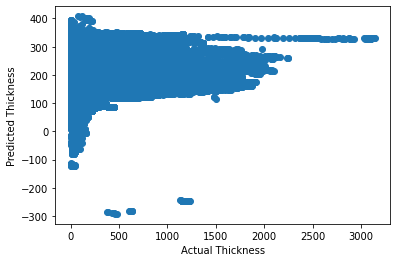

In [56]:
plt.subplots()
plt.plot(test_labels,predicted_thickness,'o')
plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['ELEVATION'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Elevation')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
#Linear regression with latitude

latitude = np.array(train_features['POINT_LAT'])

latitude_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
latitude_normalizer.adapt(latitude)


latitude_model = tf.keras.Sequential([
    latitude_normalizer,
    layers.Dense(units=1)
])

#horsepower_model.summary()

latitude_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')



In [ ]:
%%time
history = latitude_model.fit(
    train_features['POINT_LAT'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['latitude_model'] = latitude_model.evaluate(
    test_features['POINT_LAT'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = latitude_model.predict(x)

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['POINT_LAT'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Latitude')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
#Linear regression with longitude

longitude = np.array(train_features['POINT_LON'])

longitude_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
longitude_normalizer.adapt(latitude)


longitude_model = tf.keras.Sequential([
    longitude_normalizer,
    layers.Dense(units=1)
])

#horsepower_model.summary()

longitude_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [ ]:
%%time
history = longitude_model.fit(
    train_features['POINT_LON'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['longitude_model'] = longitude_model.evaluate(
    test_features['POINT_LON'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = latitude_model.predict(x)

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['POINT_LON'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Latitude')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.predict(train_features[:10])

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)